# Drink Quality by Reviews

Examine the correlation between "Rating" and "Review" to determine if the quality of a drink can be predicted based on it's reviews.

In [1]:
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/ML-Project

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML-Project


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random

import import_ipynb
import utils

# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)

importing Jupyter notebook from utils.ipynb


In [53]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

### Preprocessing the Dataset

In [5]:
# read dataset file
df = pd.read_csv('dataset.csv', sep=',')

In [6]:
# inspect 10 random instances from the dataset
df.sample(10)

,Sl.No.,Brand,Name,Reviews Date Added,Reviews do Recommend,Reviews Num Helpful,Reviews Rating,Weight,Reviews Title,Reviews Text
1263,1264,Gmax,Gmax g144105 gm44 full face red wine m,2017-01-09T22:25:24Z,NaN,NaN,4.0,NaN,NaN,easy process
227,228,Heineken,Heineken174 Lager - 6pk / 12oz Bottles,2017-09-20T01:18:35Z,True,NaN,5.0,1.0 lbs,Great beer!,"I bought this, best price and great convenienc..."
2142,2143,Carmex,"Carmex Lip Balm Original Jar - 12 PK, 12.",2017-09-23T02:53:08Z,True,NaN,5.0,NaN,Small and compact!,"The lip balm is so smooth, doesn't have a weir..."
450,451,Jim Beam,"Jim Beam Black Bourbon Whiskey, 50 mL",2017-09-20T01:18:35Z,NaN,NaN,5.0,NaN,My favorite bourbon!,Exceptionally good flavor!
1403,1404,Great Value,"Great Value Original Crescent Rolls, 8 oz",2017-09-02T07:55:36Z,True,0.0,5.0,NaN,Just as good as Pillsbury,Just as good as Pillsbury but better price
570,571,Peychauds,Peychauds Aromatic Cocktail Bitters - 10 oz,2016-01-18T14:58:07Z,NaN,NaN,NaN,12 ounces,Sazerac. Anything else,This is just one of those things you need if y...
2396,2397,Carmex,"Carmex Lip Balm Original Jar - 12 PK, 12.",2017-09-23T02:53:08Z,True,NaN,5.0,NaN,my favourite little tin tin,"This little tin of Carmex is amazing, seems to..."
2275,2276,Carmex,"Carmex Lip Balm Original Jar - 12 PK, 12.",2017-09-23T02:53:08Z,True,NaN,5.0,NaN,Been using and loving for decades...,I have been using the classic Carmex in the ja...
2725,2726,NaN,Barefoot Cellars California Sampler Wine Mixed...,2016-07-26T20:28:23Z,NaN,NaN,5.0,NaN,Great Wine One person found this helpful. Was ...,I love the fact that I can now buy Barefoot Wi...
1308,1309,Master of Mixes,"Master of Mixes Sweet'n Sour Mixer, 1 L",2017-01-14T19:38:11Z,True,NaN,NaN,10 Pounds,Great stuff!,"I am a whiskey sour lover, but imbibing only w..."


In [7]:
# replace column names with shorter, more readable names
df.columns = ['Num', 'Brand', 'Name', 'Date', 'Recommend', 'Helpful', 'Rating', 'Weight', 'Review Title', 'Review']
df.sample(5)

,Num,Brand,Name,Date,Recommend,Helpful,Rating,Weight,Review Title,Review
46,47,Wine Cube153,Red Blend - 3l Bottle - Wine Cube153,2018-01-10T18:06:27Z,True,NaN,5.0,1.0 lbs,Love It!,My boyfriend brought this home on a whim. We w...
2426,2427,Carmex,"Carmex Lip Balm Original Jar - 12 PK, 12.",2017-09-23T02:53:08Z,True,NaN,5.0,NaN,The tried and true treament for dry cracked lips,"My mother used this product, and now I use it ..."
2408,2409,Carmex,"Carmex Lip Balm Original Jar - 12 PK, 12.",2017-09-23T02:53:08Z,True,NaN,5.0,NaN,Works Everytime!!!,"I really like Carmex in general, I started wit..."
790,791,Master of Mixes,"Master of Mixes Pina Colada Mix, 1.75 L",2017-09-20T01:18:35Z,True,1.0,5.0,NaN,PIna Colada mix,"My husband and his friend, who had never had a..."
182,183,Gallo,Starborough174 Sauvignon Blanc - 750ml Bottle,2018-01-10T05:58:03Z,NaN,NaN,4.0,1.0 lbs,"Nice, Fresh, Tasty With Character",Starborough was a surprise as an alternate to ...


In [8]:
df.head(10)

,Num,Brand,Name,Date,Recommend,Helpful,Rating,Weight,Review Title,Review
0,1,Gallo,Ecco Domani174 Pinot Grigio - 750ml Bottle,2018-01-09T13:24:04Z,True,1.0,5.0,1.0 lbs,My Favorite White Wine,This a fantastic white wine for any occasion!
1,2,Fresh Craft Co.,Fresh Craft174 Mango Citrus - 4pk / 250ml Bottle,2018-01-09T17:31:52Z,True,NaN,5.0,2.45 lbs,Yum!!,"Tart, not sweet...very refreshing and delicious!"
2,3,1000 Stories,1000 Stories174 Zinfandel - 750ml Bottle,2018-01-09T17:31:51Z,True,NaN,5.0,3.09 lbs,A New Favorite!,I was given this wine so it was a delightful s...
3,4,1000 Stories,1000 Stories174 Zinfandel - 750ml Bottle,2017-10-04T18:03:12Z,True,NaN,5.0,3.09 lbs,"Bold, Flavorful, Aromatic, Delicious",This is a phenomenal wine and my new favorite ...
4,5,Wine Cube153,Pink Moscato - 3l Bottle - Wine Cube153,2018-01-10T18:06:29Z,True,1.0,5.0,1.0 lbs,"Yum! Plus, Environmentally Friendly!",4 750ml bottles for the price of two With way ...
5,6,Beck's Na,Beck's174 Non Alcoholic Beer - 6pk / 12oz Bottles,2018-01-10T18:59:18Z,True,NaN,5.0,1.0 lbs,Great Taste,I LOVE Becks NA. It tastes just like a regular...
6,7,Gallo,Apothic174 Red Blend - 750ml Bottle,2018-01-09T21:14:31Z,NaN,1.0,3.0,1.0 lbs,Simply Wonderful,This wine has a wonderful but strong aroma its...
7,8,Gallo,Apothic174 Red Blend - 750ml Bottle,2017-12-15T00:02:24Z,NaN,1.0,2.0,1.0 lbs,A Sweet Red.,I would give one more star if it came clean on...
8,9,California Roots,California Roots Moscato White Wine - 750ml,2018-01-09T13:24:06Z,True,0.0,5.0,2.65 lbs,NaN,Delicious and very affordable
9,10,Charles Charles,Charles Charles174 Red Blend - 750ml Bottle,2018-01-09T17:31:51Z,True,NaN,5.0,1.0 lbs,Charles & Charles Red Blend,This is a very smooth red with Aromas of cocoa...


In [9]:
# remove useless columns
df.drop("Num", axis=1, inplace=True)
df.drop("Date", axis=1, inplace=True)

In [10]:
# reindex rows
df.reset_index(drop=True, inplace=True)
df.head(10)

,Brand,Name,Recommend,Helpful,Rating,Weight,Review Title,Review
0,Gallo,Ecco Domani174 Pinot Grigio - 750ml Bottle,True,1.0,5.0,1.0 lbs,My Favorite White Wine,This a fantastic white wine for any occasion!
1,Fresh Craft Co.,Fresh Craft174 Mango Citrus - 4pk / 250ml Bottle,True,NaN,5.0,2.45 lbs,Yum!!,"Tart, not sweet...very refreshing and delicious!"
2,1000 Stories,1000 Stories174 Zinfandel - 750ml Bottle,True,NaN,5.0,3.09 lbs,A New Favorite!,I was given this wine so it was a delightful s...
3,1000 Stories,1000 Stories174 Zinfandel - 750ml Bottle,True,NaN,5.0,3.09 lbs,"Bold, Flavorful, Aromatic, Delicious",This is a phenomenal wine and my new favorite ...
4,Wine Cube153,Pink Moscato - 3l Bottle - Wine Cube153,True,1.0,5.0,1.0 lbs,"Yum! Plus, Environmentally Friendly!",4 750ml bottles for the price of two With way ...
5,Beck's Na,Beck's174 Non Alcoholic Beer - 6pk / 12oz Bottles,True,NaN,5.0,1.0 lbs,Great Taste,I LOVE Becks NA. It tastes just like a regular...
6,Gallo,Apothic174 Red Blend - 750ml Bottle,NaN,1.0,3.0,1.0 lbs,Simply Wonderful,This wine has a wonderful but strong aroma its...
7,Gallo,Apothic174 Red Blend - 750ml Bottle,NaN,1.0,2.0,1.0 lbs,A Sweet Red.,I would give one more star if it came clean on...
8,California Roots,California Roots Moscato White Wine - 750ml,True,0.0,5.0,2.65 lbs,NaN,Delicious and very affordable
9,Charles Charles,Charles Charles174 Red Blend - 750ml Bottle,True,NaN,5.0,1.0 lbs,Charles & Charles Red Blend,This is a very smooth red with Aromas of cocoa...


In [11]:
# check for total amount of null values in each column
print(df.isnull().sum())

Brand             65
Name               0
Recommend        979
Helpful         2264
Rating           445
Weight          1894
Review Title      44
Review             1
dtype: int64


In [12]:
# remove all rows that have no ratings or recommendations
df = df.dropna(subset=['Rating'])
df = df.dropna(subset=['Recommend'])
df.isnull().sum()

Brand              0
Name               0
Recommend          0
Helpful         1170
Rating             0
Weight          1392
Review Title      10
Review             0
dtype: int64

In [13]:
# check the all possible ratings from 1 to 5 are used
np.unique(df['Rating'])

array([1., 2., 3., 4., 5.])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1748 entries, 0 to 2815
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         1748 non-null   object 
 1   Name          1748 non-null   object 
 2   Recommend     1748 non-null   object 
 3   Helpful       578 non-null    float64
 4   Rating        1748 non-null   float64
 5   Weight        356 non-null    object 
 6   Review Title  1738 non-null   object 
 7   Review        1748 non-null   object 
dtypes: float64(2), object(6)
memory usage: 122.9+ KB


In [15]:
# change data type of "Rating" from float to integer
df['Rating'] = df['Rating'].astype(int)

# change data type of "Recommend" from object to integer
# "True" = 1, "False" = 0
df["Recommend"] = df["Recommend"].astype(int)

# check data types again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1748 entries, 0 to 2815
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         1748 non-null   object 
 1   Name          1748 non-null   object 
 2   Recommend     1748 non-null   int64  
 3   Helpful       578 non-null    float64
 4   Rating        1748 non-null   int64  
 5   Weight        356 non-null    object 
 6   Review Title  1738 non-null   object 
 7   Review        1748 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 122.9+ KB


In [16]:
# inspect correlation between numeric features
df.corr()

,Recommend,Helpful,Rating
Recommend,1.000000,0.042670,0.767292
Helpful,0.042670,1.000000,0.024891
Rating,0.767292,0.024891,1.000000


- There is a weak positive correlation between recommend and helpful. Reviews that were voted helpful tend to be about alcohol that reviewers recommend to others.
- There is a strong positive correlation between recommend and rating. The higher the rating/quality of the alcohol, then then the more likely that the reviewer would recommend it.
- There is a very weak positive correlation between helpful and rating. Alcohol that was voted helpful tend to have slightly higher ratings than reviews not considered helpful.

In [17]:
# check for duplicated reviews
df['Review'].duplicated().sum()

13

In [18]:
# remove duplicated reviews
df['Review'].drop_duplicates()

0           This a fantastic white wine for any occasion!
1        Tart, not sweet...very refreshing and delicious!
2       I was given this wine so it was a delightful s...
3       This is a phenomenal wine and my new favorite ...
4       4 750ml bottles for the price of two With way ...
                              ...                        
2811    My kids love them. So no complaints but I'm su...
2812    Easy and quick to serve, brings a smile to the...
2813                         Worked great kids loved them
2814    Walmart used to carry a Swiss water decaf coff...
2815    Great decaf coffee using Swiss water process. ...
Name: Review, Length: 1735, dtype: object

In [19]:
# clean text in reviews with natural language toolkit
!pip install nltk
import nltk

# define stopwords to remove
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
# tokenize text with regex before cleaning
from nltk import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
token = TreebankWordDetokenizer()

def clean(w):
    w = word_tokenize(w.lower()) # turn all token words lowercase
    w = [token for token in w if token not in stopwords and token.isalpha()] # remove stopwords and non-words (punctuation, numbers, etc.)
    return token.detokenize(w)

df["Clean_Reviews"] = df["Review"].apply(clean)

In [21]:
# check to make sure the reviews were cleaned correctly
df["Clean_Reviews"].sample(10)

1347             mix per directions makes great margarita
620                       product flavor bland call spicy
1796    carmex great product small size makes easy sli...
2347    works really well day long lasting moisture ov...
447     maple crown far favorite whiskey date goes gre...
2257    using carmex years yes strayed carmex path occ...
2051    using original carmex jar forever keeps lips s...
318                                         love easy mix
2135    bought last month moment used felt soothing re...
123          rum chata great mixed fireball caramel vodka
Name: Clean_Reviews, dtype: object

5    1501
4     154
3      38
1      36
2      19
Name: Rating, dtype: int64
----------------------------------------------------


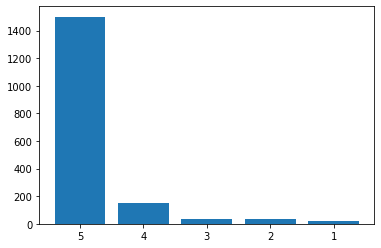

In [22]:
# check how evenly distributed the quality ratings are
classes = df['Rating'].unique()
counts = []

for i in classes:
  count = len(df[df['Rating']==i])
  counts.append(count)

print(df.Rating.value_counts())
print("----------------------------------------------------")

plt.bar(['5', '4', '3', '2', '1'], counts)
plt.show();

- There is a large difference between drinks rated 5/5 and every other rating.
- Drinks rated 5 are the most common, followed by drinks rated 4, then 3, then 1, and then 2.

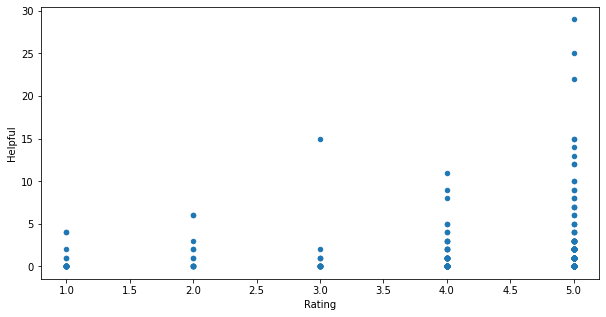

In [23]:
graph2 = df.plot(kind='scatter', x='Rating', y='Helpful');
graph2.figure.set_size_inches(10,5);

- The majority of drinks were not given a helpful rating.
- Alcohol with a rating of 5 were labled the most helpful, followed by alochol rated 4 out of 5.
- Alcohol rated 3 out of 5 by reviewers were considered the least helpful on average.

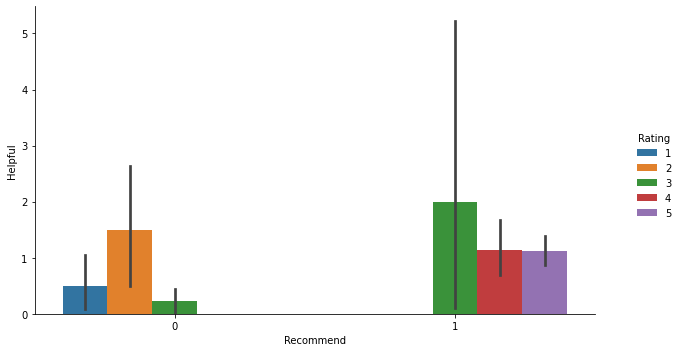

In [24]:
graph3 = sns.catplot(data=df, kind="bar", x="Recommend", y="Helpful", hue="Rating");
graph3.figure.set_size_inches(10,5);

- The recommended drinks are considered the most helpful reviews, and have ratings of 5, 4, and 3 out of 5.
- The drinks that are not recommended are considered the least helpful reviews, and received ratings of 3, 2, and 1 out of 5.

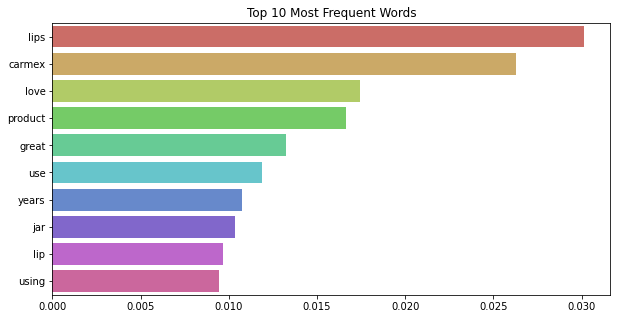

In [25]:
# plot and examine the most frequently used words in reviews
words = df["Clean_Reviews"].str.split(expand=True).stack().value_counts()
total_words = sum(words)

freq_words = words[:10]/total_words
pal = sns.color_palette("hls", 10)
graph4 = sns.barplot(x = freq_words.values, y = freq_words.index, orient="h", palette=pal)
graph4.set_title("Top 10 Most Frequent Words")
graph4.figure.set_size_inches(10,5);

# Classical Algorithm - Logistic Regression

In [26]:
# set logistic regression model
# random state added to make sure that the experiment is replicable
logreg = LogisticRegression(random_state=42, solver="lbfgs", max_iter=1000)
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Count Vectorizer Model

In [27]:
vec1 = CountVectorizer()

In [28]:
# define X and y
# split data into 66% training and 33% testing datasets
y = df.Rating.values
X = df.Clean_Reviews.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, shuffle=True, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1171,), (577,), (1171,), (577,))

In [29]:
# encode each word in each review as words using CountVectorizer
# CountVectorizer tokenizes the reviews, splitting them into a set of tokens
# it also removes punctuation and special characters
vec1.fit(X_train)
X_train = vec1.transform(X_train)

# convert texts into a numeric count representation, one word per column
X_test = vec1.transform(X_test)

In [30]:
# the dataset consists of the index of each world that is used in the train set
print(X_train[1])

  (0, 12)	2
  (0, 66)	1
  (0, 109)	1
  (0, 162)	1
  (0, 206)	1
  (0, 213)	1
  (0, 388)	2
  (0, 674)	1
  (0, 707)	1
  (0, 780)	1
  (0, 885)	1
  (0, 917)	1
  (0, 1107)	2
  (0, 1238)	1
  (0, 1294)	1
  (0, 1502)	1
  (0, 1571)	2
  (0, 1704)	1
  (0, 1721)	1
  (0, 1759)	1
  (0, 1818)	1
  (0, 2040)	1
  (0, 2082)	1
  (0, 2116)	2
  (0, 2119)	2
  (0, 2173)	1
  (0, 2209)	1
  (0, 2287)	1
  (0, 2341)	1
  (0, 2421)	1
  (0, 2549)	1
  (0, 2566)	1
  (0, 2712)	1
  (0, 2731)	1
  (0, 2746)	1
  (0, 2762)	1
  (0, 2793)	1
  (0, 2867)	2
  (0, 2872)	1
  (0, 2873)	1
  (0, 2996)	1
  (0, 3035)	1


In [31]:
# examine the new vector
# it's a sparse matrix - a data type optimized for matrices with very few non-zero elements to reduce memory load
# 1171 training samples, each with 3059 dimensions (the size of the vocabulary used in reviews)
X_train

<1171x3059 sparse matrix of type '<class 'numpy.int64'>'
	with 16494 stored elements in Compressed Sparse Row format>

In [32]:
# examine them in a dataframe
pd.DataFrame(X_train.todense(), columns=vec1.get_feature_names_out())

,able,abreava,abreva,absoloutley,absolute,absolutely,access,accessories,accident,accidentally,...,zang,zero,zesty,ziggurat,zinfindel,zing,zingy,zingzang,zippers,zustand
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# quick test to check if data frame is working
test = ['A bottle of absolute wine has zero zesty notes.']
vec1_test = vec1.transform(test)

pd.DataFrame(vec1_test.todense(), columns=vec1.get_feature_names_out())

,able,abreava,abreva,absoloutley,absolute,absolutely,access,accessories,accident,accidentally,...,zang,zero,zesty,ziggurat,zinfindel,zing,zingy,zingzang,zippers,zustand
0,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [34]:
# use logisitic regression model and calculate the accuracy
logreg.fit(X_train, y_train)

acc = logreg.score(X_test, y_test)
print("The accuracy of this model is:", acc)

The accuracy of this model is: 0.8440207972270364


### TF IDF Vectorizer Model

In [35]:
vec2 = TfidfVectorizer()

In [36]:
# define X and y
# split data into 66% training and 33% testing datasets
y = df.Rating.values
X = df.Clean_Reviews.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, shuffle=True, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1171,), (577,), (1171,), (577,))

In [37]:
# TfidfVectorizer looks at the frequency of tokens in the doc but also how often it occurs in the docs
# term frequency is normalized to give high weighs to important words and low weights to less important words so you get an average of terms 
# learn the vocabulary of the training data
vec2.fit(X_train)
X_train = vec2.transform(X_train)

# convert texts into a numeric count representation, one word per column
X_test = vec2.transform(X_test)

In [38]:
# check how the vector looks
# the dataset consists of the index of each word that is used in the train set
print(X_train[1])

  (0, 3035)	0.07097076974790902
  (0, 2996)	0.09428610790345714
  (0, 2873)	0.07283658511630575
  (0, 2872)	0.14180659504704102
  (0, 2867)	0.13720154417778913
  (0, 2793)	0.16434974765318758
  (0, 2762)	0.13732100708328454
  (0, 2746)	0.11477785447713798
  (0, 2731)	0.13946171491947115
  (0, 2712)	0.11647525987104106
  (0, 2566)	0.10321453382905296
  (0, 2549)	0.11647525987104106
  (0, 2421)	0.14439873976761305
  (0, 2341)	0.13535174676958148
  (0, 2287)	0.1287517498710341
  (0, 2209)	0.11561192146747724
  (0, 2173)	0.17142748033751612
  (0, 2119)	0.32869949530637516
  (0, 2116)	0.18857221580691427
  (0, 2082)	0.10832300619967841
  (0, 2040)	0.06301064163356962
  (0, 1818)	0.11926344244089447
  (0, 1759)	0.10649975592825381
  (0, 1721)	0.11477785447713798
  (0, 1704)	0.1287517498710341
  (0, 1571)	0.32869949530637516
  (0, 1502)	0.05263831263772907
  (0, 1294)	0.12475335841992524
  (0, 1238)	0.12734550314049725
  (0, 1107)	0.18007876440694534
  (0, 917)	0.15885983167415682
  (0, 885)	

In [39]:
# examine the new vector
# it's a sparse matrix - a data type optimized for matrices with very few non-zero elements to reduce memory load
# 1171 training samples, each with 3059 dimensions (the size of the vocabulary used in reviews)
X_train

<1171x3059 sparse matrix of type '<class 'numpy.float64'>'
	with 16494 stored elements in Compressed Sparse Row format>

In [40]:
# examine them in a dataframe
pd.DataFrame(X_train.todense(), columns=vec2.get_feature_names_out())

,able,abreava,abreva,absoloutley,absolute,absolutely,access,accessories,accident,accidentally,...,zang,zero,zesty,ziggurat,zinfindel,zing,zingy,zingzang,zippers,zustand
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# quick test to check if data frame is working
test = ['A bottle of absolute wine has zero zesty notes.']
vec2_test = vec2.transform(test)

pd.DataFrame(vec2_test.todense(), columns=vec2.get_feature_names_out())

,able,abreava,abreva,absoloutley,absolute,absolutely,access,accessories,accident,accidentally,...,zang,zero,zesty,ziggurat,zinfindel,zing,zingy,zingzang,zippers,zustand
0,0.0,0.0,0.0,0.0,0.384616,0.0,0.0,0.0,0.0,0.0,...,0.0,0.473674,0.473674,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# use logisitic regression model and calculate the accuracy
logreg.fit(X_train, y_train)

acc = logreg.score(X_test, y_test)
print("The accuracy of this model is:", acc)

The accuracy of this model is: 0.8492201039861352


- With this dataset, the TFIDF Vectorizor model returns a slightly more accurate result than the Count Vectorizer

### Model Evaluation

In [43]:
# predict output for test data
y_test_pred = logreg.predict(X_test)

In [44]:
# evaluate how well the model did
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       1.00      0.02      0.03        57
           5       0.85      1.00      0.92       489

    accuracy                           0.85       577
   macro avg       0.37      0.20      0.19       577
weighted avg       0.82      0.85      0.78       577



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Precision is the ability of the model to not label negative data as positive
- Recall is the ability of the model to find all the positive data
- f1-score is the weighted average of percision and recall
- Accuracy is how often the model correctly predicts negative or positive data

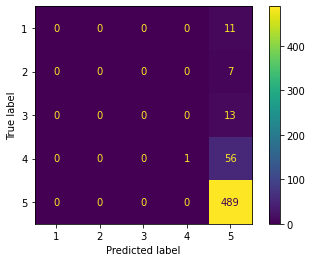

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);

### Pipeline

In [46]:
# implement a pipeline to try and increase model accuracy
scaler = MaxAbsScaler()
log = LogisticRegression(random_state=42)

pipe = make_pipeline(scaler, log)

In [47]:
param_grid = [{
    'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 
    'logisticregression__max_iter': [100, 1000, 10000],
    'logisticregression__solver': ['sag', 'saga', 'newton-cg', 'lbfgs']
    }]

gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1, refit=True)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10,
                                                    100, 1000],
                          'logisticregression__max_iter': [100, 1000, 10000],
                          'logisticregression__solver': ['sag', 'saga',
                                                         'newton-cg',
                                                         'lbfgs']}],
             scoring='f1_macro', verbose=1)

In [48]:
gs.best_estimator_

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('logisticregression',
                 LogisticRegression(C=100, max_iter=1000, random_state=42,
                                    solver='saga'))])

In [49]:
gs.best_score_

0.32427889659496206

In [50]:
gs.best_params_

{'logisticregression__C': 100,
 'logisticregression__max_iter': 1000,
 'logisticregression__solver': 'saga'}

In [51]:
y_test_pred = gs.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.25      0.09      0.13        11
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        13
           4       0.20      0.12      0.15        57
           5       0.87      0.96      0.91       489

    accuracy                           0.82       577
   macro avg       0.26      0.23      0.24       577
weighted avg       0.76      0.82      0.79       577



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Implementing gridsearch in this situation did not increase the overall accuracy of the model, even though the accuracy for the individual ratings "1" and "4" improved marginally

In [55]:
print("MSE:", mse(y_true = y_test, y_pred = y_test_pred))
print("MAE:", mae(y_true = y_test, y_pred = y_test_pred))

MSE: 0.5008665511265165
MAE: 0.25476603119584057


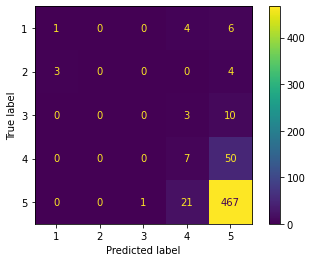

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);

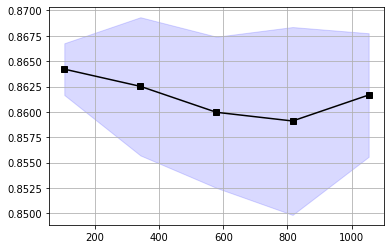

In [57]:
from sklearn.model_selection import learning_curve, validation_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, X=X_train, y=y_train, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, test_mean, color='black', marker='s');
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='blue')
plt.grid()

In [58]:
# test if model is more accurate than a dummy model
from sklearn.dummy import DummyClassifier
dummy1 = DummyClassifier(strategy="most_frequent")
dummy2 = DummyClassifier(strategy="stratified")

In [59]:
# most_frequent - returns most frequent class label
dummy1.fit(X_train, y_train)
dummy1.score(X_train, y_train)

0.8642186165670367

In [60]:
# stratified - returns random samples from a distribution based on prior probabilities
dummy2.fit(X_train, y_train)
dummy2.score(X_train, y_train)

0.7557643040136636